In [2]:
# TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
from Functions import total_function_multiprocessing
from time import sleep

list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
list_minutes = [360, 720, 1440, 1440*2, 1440*3]
list_event_buy_volume = [0.65, 0.75, 0.85, 0.9]
list_event_volume = [6,10,15,20,30,50]
n_processes = 8
analysis_timeframe=6.5

LOAD_DATA = False
UNLOCK = True
n_iterations = 2

for i in range(n_iterations):
    if UNLOCK:
        shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA, analysis_timeframe)
    iterazione = i+1
    msg=f'{iterazione}/{n_iterations} COMPLETED'
    print(msg)

    print('sleeping')
    sleep(20)

/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-22-11-2023 does not exist. Making the request to the server..
StatusCode for getting get-benchmarkinfo: 200
total_combinations :  5880
/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-22-11-2023 exists. Loading the file...
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-07-05-2023-0-0.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-07-06-2023-19-49.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-11-06-2023-14-20.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-15-06-2023-14-20.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-19-06-2023-10-45.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-23-06-2023-08-02.json
Nothing to retrieve from /Users/albe

In [ ]:
# # TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
# # INTEGRATION
# from Functions import total_function_multiprocessing
# from time import sleep


# list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
# list_vol = ['vol_5m']
# #list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
# list_minutes = [360, 720, 1440, 1440*2, 1440*3]
# list_event_buy_volume = [0.85, 0.9]
# list_event_volume = [6]
# n_processes = 8
# analysis_timeframe = 7

# LOAD_DATA = False
# FREE_LOCK = False

# for i in range(1):
#     print(f'ITERATION {i}')
#     if FREE_LOCK:
#         shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA,
#                                                       analysis_timeframe=analysis_timeframe, INTEGRATION=True)
#     sleep(20)
    

In [ ]:
# # TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING LESS RAM

# from Functions import total_function_multiprocessing_lessRAM
# list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
# list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
# list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
# list_event_buy_volume = [0.65, 0.75, 0.85]
# list_event_volume = [4,6,8,12,20]
# n_processes = 8

# SLICE_I = 1
# LOAD_DATA = False
# FREE_LOCK = True

# if FREE_LOCK:
#     shared_data = total_function_multiprocessing_lessRAM(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA, SLICE_I)

# import os
# duration = 2  # seconds
# freq = 440  # Hz
# os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))


In [1]:
# # DOWNLOAD AND SHOW NESTED OUTPUT FROM TOTAL MULTIPROCESSING
# ONLY GROUP_COINS = TRUE
from Functions import nested_download_show_output
from datetime import datetime
import pandas as pd
pd.set_option('display.max_rows', None)

# minimum_event_number_list MUST BE a list IN REVERSE ORDER
minimum_event_number_list = [200, 100]
minimum_coin_number = 0
mean_threshold = 0.5
lb_threshold = -15
frequency_threshold = 1
best_coins_volatility = 1
early_validation = datetime(2023,9,24)
early_validation = False
group_coins=True
std_multiplier = 4

output, info = nested_download_show_output(minimum_event_number_list=minimum_event_number_list, minimum_coin_number=minimum_coin_number,
                                      mean_threshold=mean_threshold, lb_threshold=lb_threshold, frequency_threshold=frequency_threshold, group_coins=group_coins,
                                      best_coins_volatility=best_coins_volatility, early_validation=early_validation, std_multiplier=std_multiplier)

df = pd.DataFrame(output).transpose()
df.sort_values(by=['mean'], ascending=False)

Download completed in 7.58 seconds
There are 10 keys for mininum_event_number: 200
There are 28 keys for mininum_event_number: 100


,mean,std,n_coins,n_events,upper_bound,lower_bound,frequency/month
buy_vol_3h:0.85/vol_15m:20/timeframe:1440,1.193800,3.090400,62.0,193.0,4.284200,-1.896600,35.74
buy_vol_3h:0.85/vol_60m:10/timeframe:1440,1.140192,2.839808,35.0,103.0,3.980000,-1.699615,19.43
buy_vol_3h:0.85/vol_15m:30/timeframe:1440,1.075797,2.681449,46.0,119.0,3.757246,-1.605652,22.59
buy_vol_3h:0.75/vol_30m:30/timeframe:720,1.061121,4.140862,78.0,183.0,5.201983,-3.079741,34.75
buy_vol_30m:0.85/vol_60m:15/timeframe:2880,0.990294,4.823725,73.0,159.0,5.814020,-3.833431,29.81
buy_vol_3h:0.85/vol_60m:6/timeframe:1440,0.949352,3.051204,71.0,210.0,4.000556,-2.101852,38.89
buy_vol_5m:0.85/vol_60m:50/timeframe:1440,0.946972,4.755046,79.0,127.0,5.702018,-3.808073,23.96
buy_vol_6h:0.75/vol_60m:20/timeframe:360,0.939846,3.276615,48.0,102.0,4.216462,-2.336769,19.74
buy_vol_3h:0.85/vol_30m:15/timeframe:2880,0.938784,2.889595,49.0,128.0,3.828378,-1.950811,23.85
buy_vol_3h:0.85/vol_5m:50/timeframe:1440,0.917353,2.936863,64.0,199.0,3.854216,-2.019510,36.85


In [ ]:
# DOWNLOAD AND SHOW OUTPUT FROM TOTAL MULTIPROCESSING
# GROUP_COINS = TRUE
# from Functions import download_show_output
# import pandas as pd
# from datetime import datetime
# pd.set_option('display.max_rows', None)

# minimum_event_number = 100
# minimum_event_number_list = [minimum_event_number]
# minimum_coin_number = 5
# mean_threshold = 0.5
# lb_threshold = -15
# frequency_threshold = 2
# group_coins = True
# best_coins_volatility = 1
# std_multiplier = 4
# early_validation = datetime(2023,9,15)
# #early_validation = False

# output, info = download_show_output(minimum_event_number=minimum_event_number, minimum_coin_number=minimum_coin_number,
#                                       mean_threshold=mean_threshold, lb_threshold=lb_threshold, frequency_threshold=frequency_threshold, early_validation=early_validation,
#                                        group_coins=group_coins, best_coins_volatility=best_coins_volatility, std_multiplier=std_multiplier)
# df = pd.DataFrame(output).transpose()
# df.sort_values(by=['mean'], ascending=False)
# #df.sort_values(by=['lower_bound'], ascending=False)

There are 0 event_keys that are in the riskmanagement configuration
There are 0 event_keys that have been discarded in the riskmanagement configuration


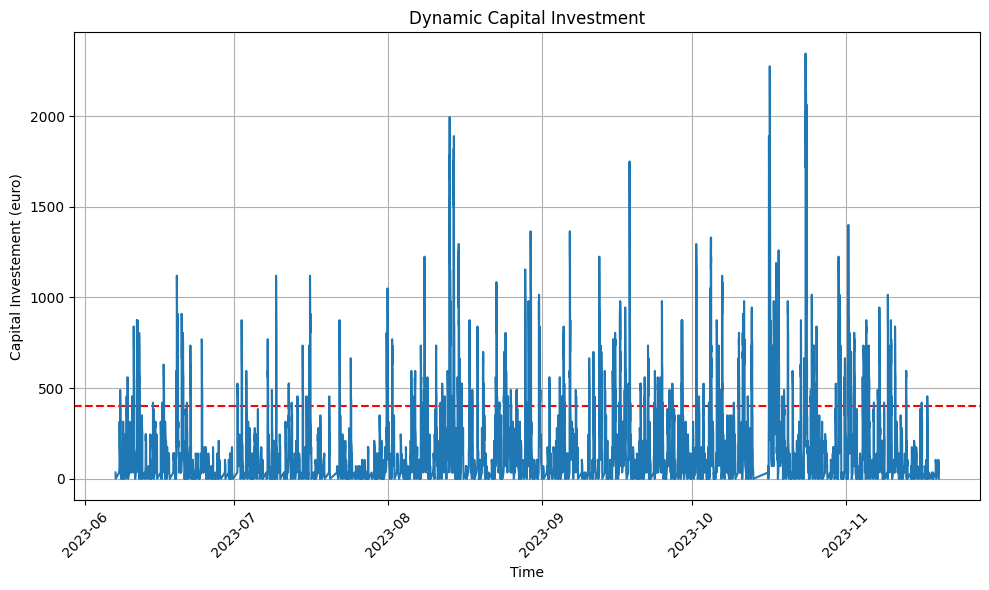

In [4]:
from Functions import check_investment_amount
check_investment_amount(info, output, investment_amount=35)

In [ ]:
key = 'buy_vol_3h:0.75/vol_30m:30/timeframe:720/vlty:3'

In [ ]:
from Functions import getTimeseries
response = getTimeseries(info, key, check_past=1440, look_for_newdata=True, plot=True)

In [ ]:
from Functions import plot_live_timeseries
risk_management_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-9-27-[50, 35, 25, 15, 5]-3-212.json"
plot_live_timeseries(risk_management_path, filter_live=False, filter_best=50)

In [ ]:
from Functions import infoTimeseries
#key = 'buy_vol_5m:0.65/vol_24h:8/timeframe:4320/vlty:1'
timeseries_info = infoTimeseries(info, key)
timeseries_info


In [ ]:
# ANALYZE RISKMANAGEMENT FOR ONLY 1 KEY
pd.set_option('display.max_colwidth', None)

from Functions import RiskManagement
import pandas as pd
pd.set_option('display.max_rows', None)
key = 'buy_vol_3h:0.75/vol_30m:30/timeframe:720'
df1, df2, best_risk_key, optimized_riskconfiguration_results = RiskManagement(key, investment_per_event=100, early_validation=False)
df1 = df1.sort_values(by=['mean'], ascending=False)
df2 = df2.sort_values(by=['events'], ascending=True)

#result = pd.concat([df1, df2], axis=0)
print(df2)
df1

In [ ]:
# ANALYZE THE RISKMANAGEMENT OF ALL KEYS FROM INFO 
from Functions import RiskConfiguration
optimized_gain_threshold = 0
mean_gain_threshold = 0.5
DISCOVER=False

riskmanagement_conf = (minimum_event_number_list, minimum_coin_number, mean_threshold, lb_threshold, frequency_threshold, group_coins, best_coins_volatility, std_multiplier, early_validation)
df, none_riskmanagement_path  = RiskConfiguration(info, riskmanagement_conf, optimized_gain_threshold, mean_gain_threshold, DISCOVER=DISCOVER)
df

In [11]:
from Functions import load_riskconfiguration
another_riskconfiguration = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-11-23-[200, 100]-0.5-VolFalse-MeanThrsl0.8-672.json"

#another_riskconfiguration = None

df = load_riskconfiguration(another_riskconfiguration)
df

Total events per month on average: 225
Optimized gain each month (percentage) for each event: 0.016829564444444445 euro with investment amount 100 euro per event
Optimized gain each month: 378 euro with investment amount 100 euro per event
Mean gain each month (percentage) for each event: 0.009798484444444443 euro with investment amount 100 euro per event
Mean gain each month: 220 euro with investment amount 100 euro per event
{
    "minimum_event_number": [
        200,
        100
    ],
    "minimum_coin_number": 0,
    "mean_threshold": 0.5,
    "lb_threshold": -15,
    "frequency_threshold": 1,
    "group_coins": true,
    "best_coins_volatility": 1,
    "std_multiplier": 4,
    "early_validation": false,
    "timestamp": "2023-11-23T12:39:48.622415"
}


,keys,golden_zone,step_golden,loss_zone,step_loss,optimized_gain,optimized_std,mean_gain,median_gain,std_gain,frequency,n_events
5,buy_vol_3h:0.75/vol_30m:30/timeframe:720,0.1,0.05,-0.025,0.05,1.96,8.50,1.13,0.92,7.62,34.75,183
0,buy_vol_3h:0.75/vol_15m:50/timeframe:720,0.6,0.15,-0.025,0.05,1.82,8.82,1.06,0.91,7.11,38.11,202
1,buy_vol_3h:0.75/vol_60m:15/timeframe:720,0.2,0.1,-0.025,0.05,1.77,8.86,0.97,0.75,7.30,39.39,214
2,buy_vol_30m:0.85/vol_15m:50/timeframe:1440,0.1,0.025,-0.025,0.05,1.75,7.41,0.93,0.85,5.80,20.32,107
4,buy_vol_60m:0.85/vol_60m:15/timeframe:360,0.6,0,-0.025,0.05,1.63,7.18,1.04,1.11,5.96,19.49,102
7,buy_vol_3h:0.85/vol_30m:15/timeframe:2880,0.3,0.025,-0.025,0.15,1.50,6.89,0.96,1.03,5.70,23.85,128
6,buy_vol_6h:0.75/vol_60m:20/timeframe:360,0.6,0,-0.025,0.05,1.44,7.52,0.83,0.95,6.26,19.74,102
3,buy_vol_30m:0.85/vol_60m:15/timeframe:2880,0.1,0.025,-0.025,0.15,1.34,6.40,0.81,0.84,5.29,29.81,159


In [1]:
from Functions import filter_existing_riskconfiguration
import re
file_path = '/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-11-23-[200, 100]-0.5-VolFalse-MeanThrsl0.5-672.json'

mean_gain_threshold = 0.8
filter_existing_riskconfiguration(file_path, mean_gain_threshold)

In [ ]:
from Functions import send_riskconfiguration
response = send_riskconfiguration()

Loading analysis.json for both scenarios: OPTIMIZED or not
OPTIMIZED ANALYSIS
Loading data from analysis.json
There is only one JSON associated with buy_vol_3h_0.75_vol_15m_50_timeframe_720
Timeseries has been downloaded
No need to update optimized_results for buy_vol_3h:0.75/vol_15m:50/timeframe:720
There is only one JSON associated with buy_vol_3h_0.75_vol_60m_15_timeframe_720
Timeseries has been downloaded
No need to update optimized_results for buy_vol_3h:0.75/vol_60m:15/timeframe:720
There is only one JSON associated with buy_vol_30m_0.85_vol_15m_50_timeframe_1440
Timeseries has been downloaded
No need to update optimized_results for buy_vol_30m:0.85/vol_15m:50/timeframe:1440
There is only one JSON associated with buy_vol_30m_0.85_vol_60m_15_timeframe_2880
Timeseries has been downloaded
No need to update optimized_results for buy_vol_30m:0.85/vol_60m:15/timeframe:2880
There is only one JSON associated with buy_vol_60m_0.85_vol_60m_15_timeframe_360
Timeseries has been downloaded
No

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


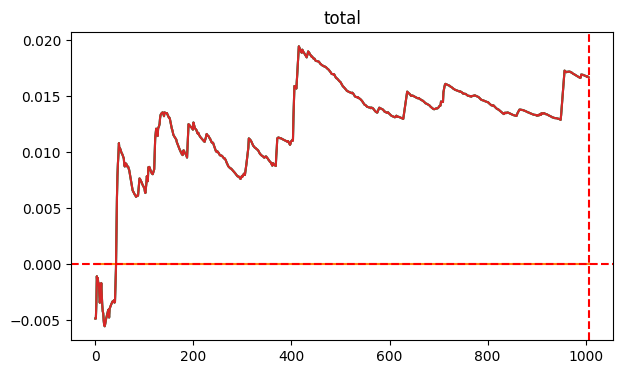

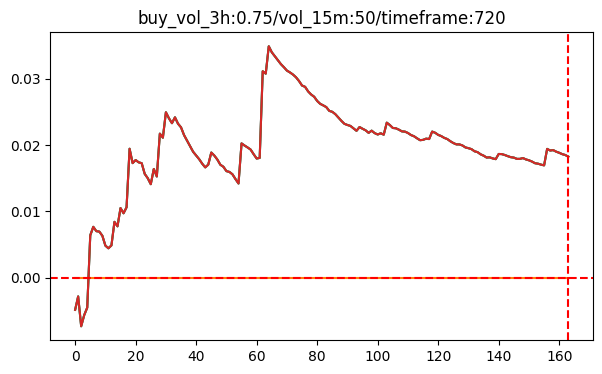

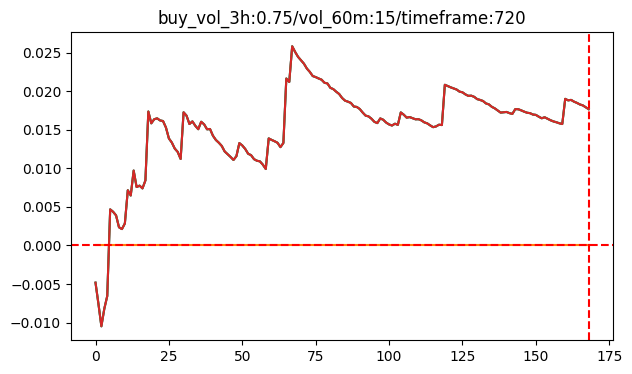

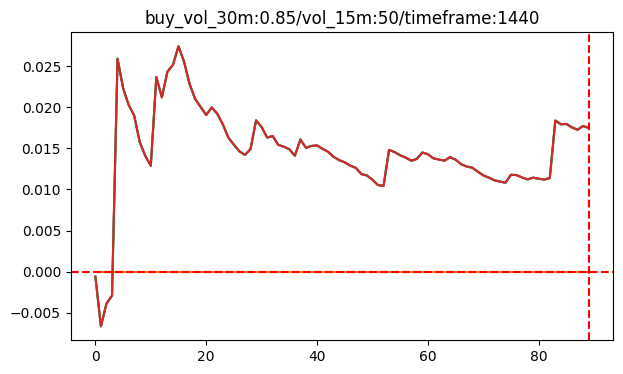

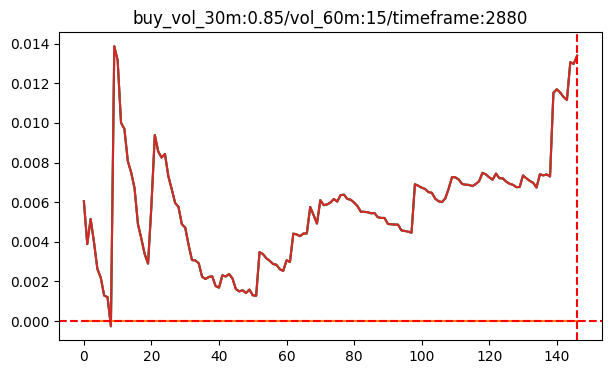

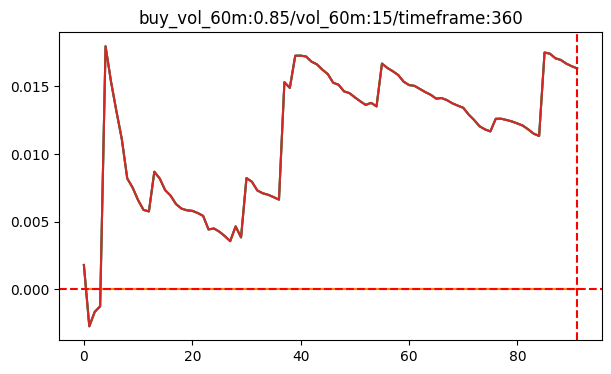

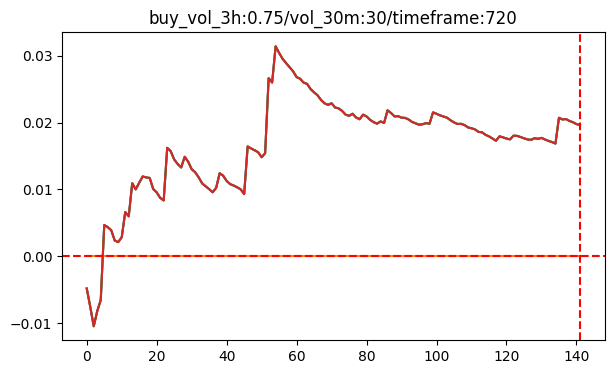

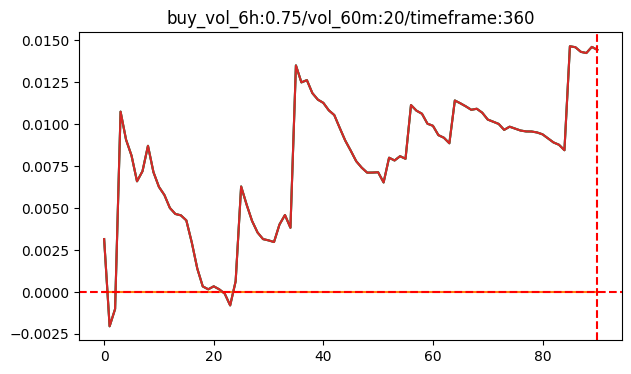

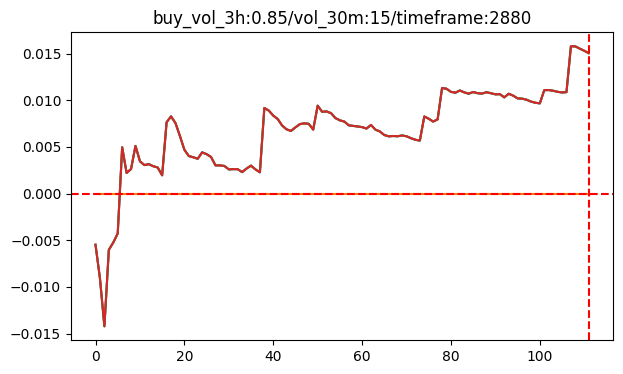

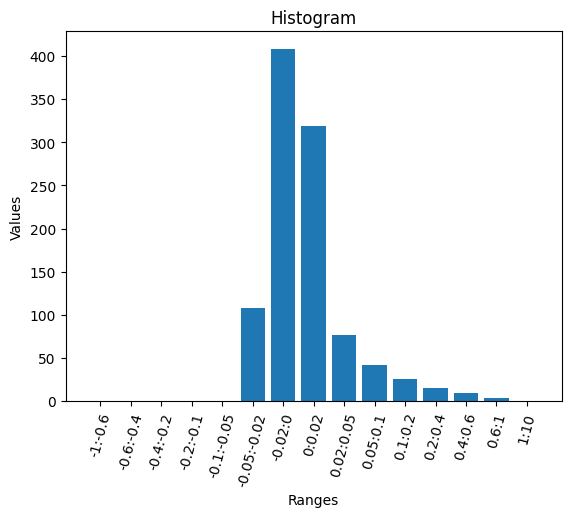

Positive events: 459
Negative events: 548
Biggest Drop: 32.54 at 2023-10-27T20:38:06.077482


,event,mean_series,mean_event,balance,coin,event_key,buy_price,exit_price,timestamp_exit,max_price,...,buy_2h,buy_3h,buy_6h,buy_12h,buy_18h,buy_1d,buy_2d,buy_3d,buy_5d,buy_7d
0,2023-06-07T21:05:02.091242,-0.004834,-0.004834,999.69,ALPACAUSDT,buy_vol_3h:0.75/vol_15m:50/timeframe:720,0.16550,0.16470,2023-06-07T22:03:02.668823,0.1664,...,0.3550,0.393,0.6740,0.3200,0.5233,0.6095,NaN,NaN,NaN,NaN
1,2023-06-07T21:05:02.091242,-0.004834,-0.004834,999.38,ALPACAUSDT,buy_vol_3h:0.75/vol_60m:15/timeframe:720,0.16550,0.16470,2023-06-07T22:03:02.668823,0.1664,...,0.3550,0.393,0.6740,0.3200,0.5233,0.6095,NaN,NaN,NaN,NaN
2,2023-06-07T21:05:02.091242,-0.003424,-0.000604,999.34,ALPACAUSDT,buy_vol_30m:0.85/vol_15m:50/timeframe:1440,0.16550,0.16540,2023-06-07T23:01:02.071667,0.1664,...,0.2550,0.326,0.6150,0.7382,1.0000,0.9500,NaN,NaN,NaN,NaN
3,2023-06-07T21:05:02.091242,-0.001057,0.006042,999.73,ALPACAUSDT,buy_vol_30m:0.85/vol_60m:15/timeframe:2880,0.16550,0.16650,2023-06-08T00:56:02.347196,0.1665,...,0.2550,0.326,0.6150,0.7382,1.0000,0.9500,NaN,NaN,NaN,NaN
4,2023-06-07T21:05:02.091242,-0.001813,-0.004834,999.42,ALPACAUSDT,buy_vol_3h:0.75/vol_30m:30/timeframe:720,0.16550,0.16470,2023-06-07T22:03:02.668823,0.1664,...,0.3550,0.393,0.6740,0.3200,0.5233,0.6095,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2023-11-14T03:56:03.567962,0.016744,-0.023075,2091.58,FISUSDT,buy_vol_3h:0.75/vol_15m:50/timeframe:720,0.35970,0.35140,2023-11-14T04:55:03.554667,0.3680,...,0.2922,0.304,0.4264,0.4920,0.4610,0.4690,0.451,0.3780,0.448,0.487
1003,2023-11-14T03:56:03.567962,0.016704,-0.023075,2090.08,FISUSDT,buy_vol_3h:0.75/vol_60m:15/timeframe:720,0.35970,0.35140,2023-11-14T04:55:03.554667,0.3680,...,0.2922,0.304,0.4264,0.4920,0.4610,0.4690,0.451,0.3780,0.448,0.487
1004,2023-11-15T03:13:04.919145,0.016761,0.073874,2094.88,ELFUSDT,buy_vol_30m:0.85/vol_60m:15/timeframe:2880,0.42640,0.45790,2023-11-15T06:19:05.163637,0.4735,...,0.6900,0.450,0.6550,0.6440,0.3380,0.5827,0.579,0.6560,0.771,0.544
1005,2023-11-16T07:22:05.764759,0.016731,-0.013354,2094.01,ACMUSDT,buy_vol_3h:0.85/vol_30m:15/timeframe:2880,1.94700,1.92100,2023-11-16T11:13:06.031993,1.9470,...,0.2670,0.226,0.4800,0.4440,0.3080,0.4340,0.373,0.5245,0.550,0.430


In [10]:
from Functions import analyzeRiskManagementPerformance

riskmanagement_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-11-23-[200, 100]-0.5-VolFalse-MeanThrsl0.8-672.json"
OPTIMIZED=True
DISCOVER=False

event_investment_amount=65


df, biggest_drop, biggest_drop_date, positive_outcome, negative_outcome, PERFORMANCE_SCENARIOS = analyzeRiskManagementPerformance(riskmanagement_path, OPTIMIZED, DISCOVER, event_investment_amount)
import pandas as pd
pd.set_option('display.max_rows', 1000)
print(f'Positive events: {positive_outcome}')
print(f'Negative events: {negative_outcome}')
print(f'Biggest Drop: {biggest_drop} at {biggest_drop_date}')

df

['buy_vol_3h:0.75/vol_15m:50/timeframe:720', 'buy_vol_3h:0.75/vol_60m:15/timeframe:720', 'buy_vol_30m:0.85/vol_15m:50/timeframe:1440', 'buy_vol_30m:0.85/vol_60m:15/timeframe:2880', 'buy_vol_60m:0.85/vol_60m:15/timeframe:360', 'buy_vol_3h:0.75/vol_30m:30/timeframe:720', 'buy_vol_6h:0.75/vol_60m:20/timeframe:360', 'buy_vol_3h:0.85/vol_30m:15/timeframe:2880']
Download completed in 6.72 seconds
There are 10 keys for mininum_event_number: 200
There are 28 keys for mininum_event_number: 100
There are 8 event_keys that are in the riskmanagement configuration
There are 22 event_keys that have been discarded in the riskmanagement configuration


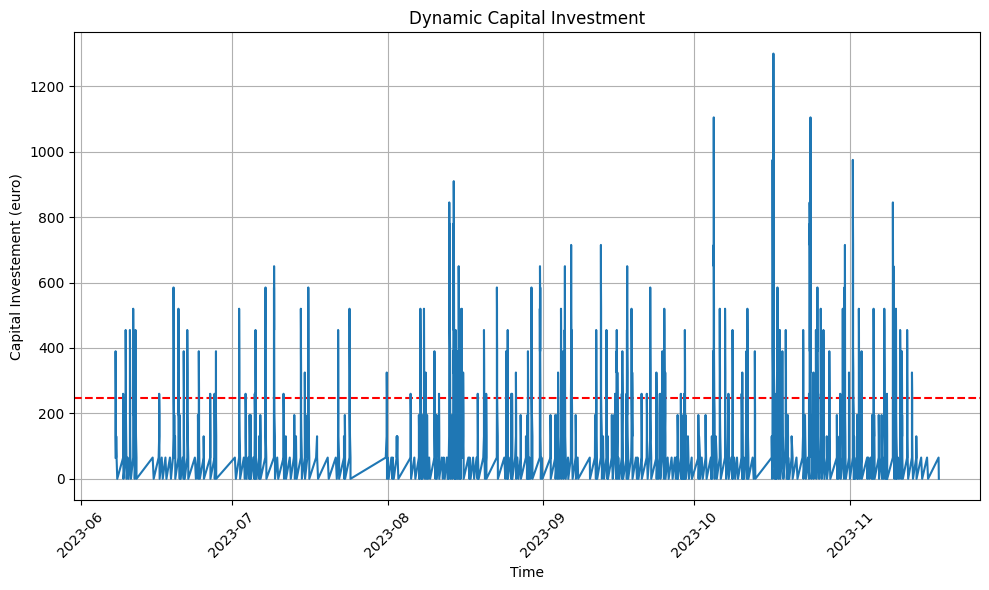

In [8]:
from Functions import check_investment_amount
info=None
output=None
riskmanagement_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-11-23-[200, 100]-0.5-VolFalse-MeanThrsl0.8-672.json"
check_investment_amount(info, output, investment_amount=65, riskmanagement_path=riskmanagement_path)